In [2]:
import os
import subprocess
from types import SimpleNamespace
import tarfile

from IPython.display import Image, display

Dataset:

- Manuscript: https://www.nature.com/articles/s41588-025-02193-3#data-availability
- 10x: https://www.10xgenomics.com/platforms/visium/product-family/dataset-human-crc
- 10x (alt): https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-human-crc
- GEO: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE280318
- SRA: https://www.ncbi.nlm.nih.gov/Traces/study/?acc=PRJNA1177833&f=librarysource_s%3An%3Atranscriptomic%2520single%2520cell%3Blibrary_type_sam_s_dpl277_s%3An%3Agene%2520expression%3Ac&o=library_name_s%3Aa&s=SRR31116645,SRR31116649,SRR31116653,SRR31116657,SRR31116661,SRR31116665,SRR31116669,SRR31116673,SRR31116646,SRR31116650,SRR31116654,SRR31116658,SRR31116662,SRR31116666,SRR31116670,SRR31116674"

In [3]:
gpu_id = 0
n_processes = 16

os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

In [4]:
code_dir = os.path.join(os.path.dirname(os.getcwd()), "data_processing")
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data_varseek")
dir_output = os.path.join(data_dir, "output")

xenium_output_data_dir = os.path.join(data_dir, "Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE_outs")
he_dir = os.path.join(xenium_output_data_dir, "he_data")
variant_data_dir = os.path.join(data_dir, "variant_data")
sequencing_data_raw_dir = os.path.join(data_dir, "sequencing_data_raw")
vk_ref_dir = os.path.join(data_dir, "vk_ref_out")
vk_count_dir = os.path.join(data_dir, "vk_count_out")

for dir_path in [data_dir, xenium_output_data_dir, he_dir, variant_data_dir, sequencing_data_raw_dir, vk_ref_dir, vk_count_dir]:  # cell_feature_matrix_dir will be created by data download
    os.makedirs(dir_path, exist_ok=True)

nucleus_boundaries_path = os.path.join(xenium_output_data_dir, "nucleus_boundaries.csv.gz")
cell_feature_matrix_dir = os.path.join(xenium_output_data_dir, "cell_feature_matrix")
he_image_path = os.path.join(he_dir, "Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE_he_image.ome.tif")
alignment_csv_path = os.path.join(he_dir, "Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE_he_imagealignment.csv")
SRA_accession_path = os.path.join(data_dir, "SRR_Acc_List_scrnaseq_crc.txt")
idx_path = os.path.join(vk_ref_dir, "cosmic_cmc_index.idx")
t2g_path = os.path.join(vk_ref_dir, "cosmic_cmc_t2g.txt")

hovernet_dir = "/mnt/gpussd2/jrich/Desktop/hover_net"
if not os.path.exists(hovernet_dir):
    raise ValueError(f"Please clone the Hover-Net repository to {hovernet_dir} before proceeding. See readme for details.")

## Setup - Download data

#### 1. Download the Xenium data subset — P5

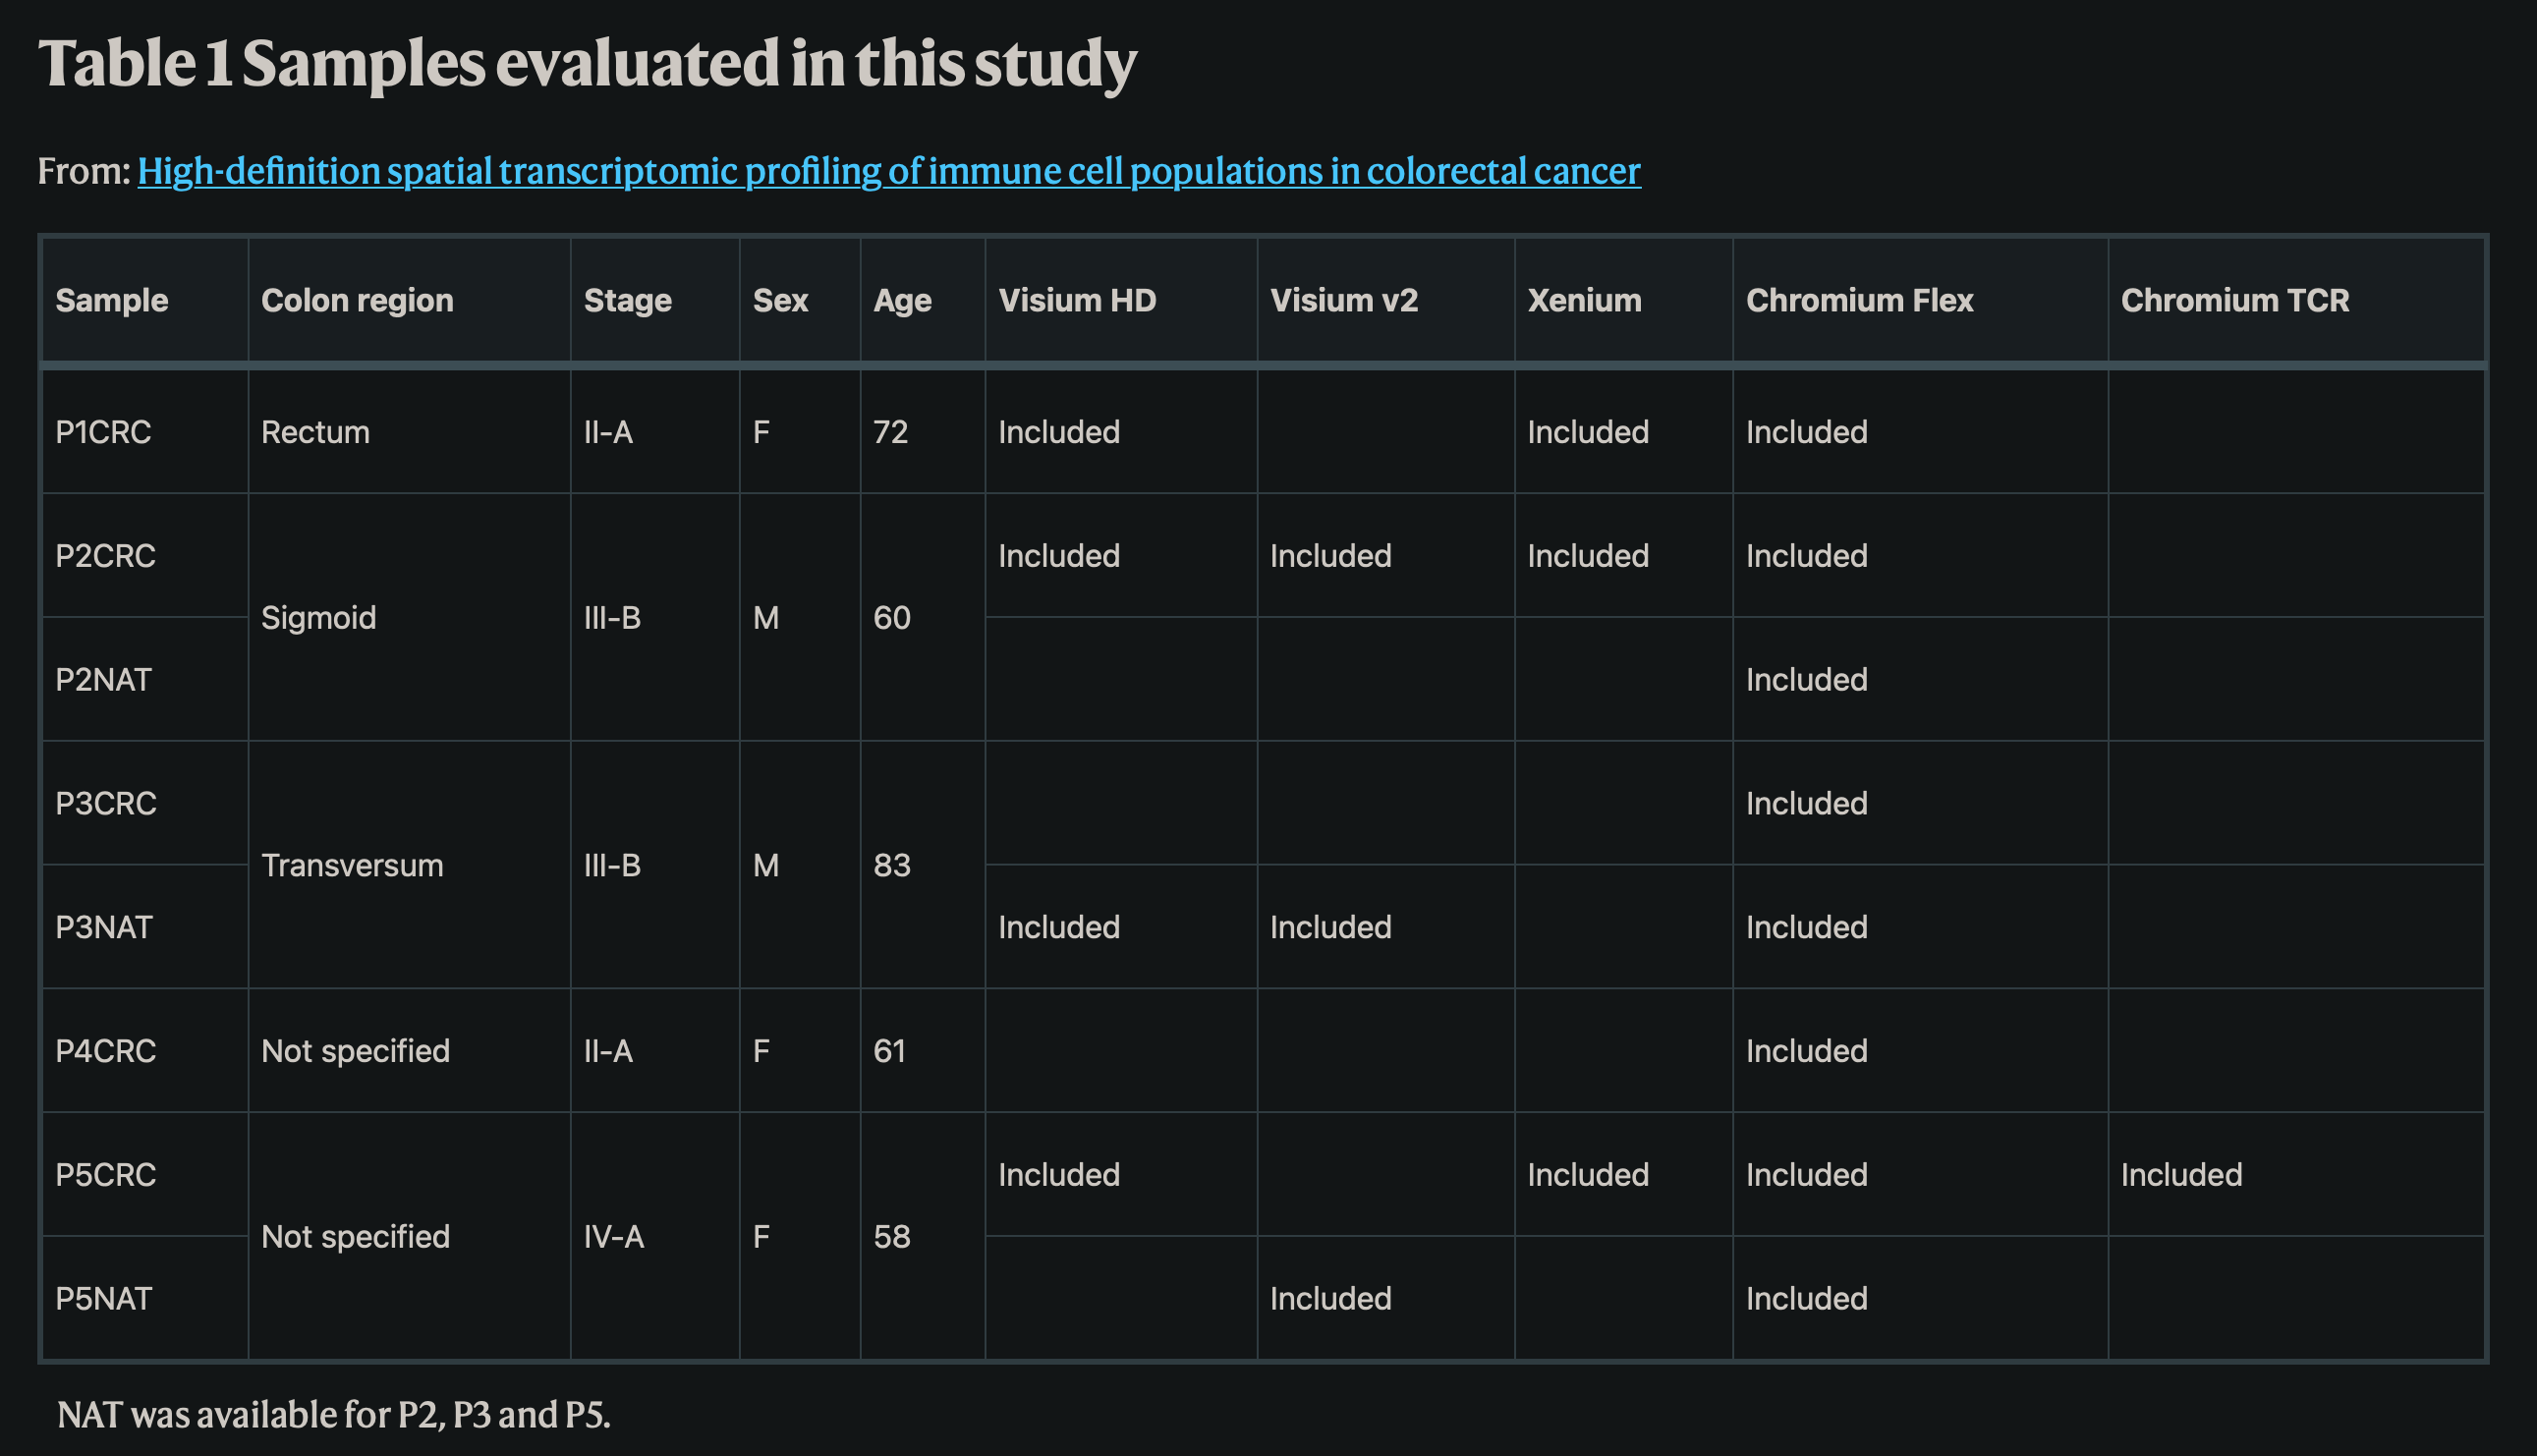

In [5]:
display(Image(filename="Table_1.png", width=800))

In [ ]:
%%time

# scRNA-seq FASTQ accession file
if not os.path.exists(SRA_accession_path):
    !wget -O {SRA_accession_path} https://caltech.box.com/shared/static/kdevjpq4r04gxwps5vmwccmba8rzy37n.txt

# H&E image and alignment file
if not os.path.exists(alignment_csv_path):
    !wget -O {alignment_csv_path} https://cf.10xgenomics.com/samples/xenium/2.0.0/Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE/Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE_he_imagealignment.csv
if not os.path.exists(he_image_path):
    !wget -O {he_image_path} https://cf.10xgenomics.com/samples/xenium/2.0.0/Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE/Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE_he_image.ome.tif

# Xenium files
if not os.path.exists(nucleus_boundaries_path):
    !wget -O {xenium_output_data_dir}.zip https://cf.10xgenomics.com/samples/xenium/2.0.0/Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE/Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE_outs.zip
    !unzip -d {xenium_output_data_dir} {xenium_output_data_dir}.zip

# varseek files
if not os.path.exists(idx_path):
    !wget -O {idx_path} https://caltech.box.com/shared/static/f58qvvmp6en4dha28d7pakafg8j9jzqi.idx
if not os.path.exists(t2g_path):
    !wget -O {t2g_path} https://caltech.box.com/shared/static/taqo1cyswui69rdiy3jqpxdtsgbnin10.txt

if not os.path.exists(cell_feature_matrix_dir):
    if os.path.exists(f"{cell_feature_matrix_dir}.tar.gz"):
        with tarfile.open(f"{cell_feature_matrix_dir}.tar.gz", "r:gz") as tar:
            tar.extractall(path=xenium_output_data_dir)

CPU times: user 0 ns, sys: 256 μs, total: 256 μs
Wall time: 264 μs


The following files from the Xenium bundle are required:
- nucleus boundaries: data_varseek/Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE_outs/nucleus_boundaries.csv.gz
- cell_feature_matrix: data_varseek/Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE_outs/cell_feature_matrix/
- H&E image: data_varseek/Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE_outs/he_data/Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE_he_image.ome.tif

In [ ]:
# Change working directory
os.chdir(code_dir)

# Step 0

Align H&E image to Xenium data

In [ ]:
command = f"""
python 0_align_he_to_xenium.py \
    --fp_he_img {he_image_path} \
    --fp_alignment_csv {alignment_csv_path} \
    --dir_output {dir_output}
"""
# print(command)
os.system(command)



python 0_align_he_to_xenium.py     --fp_he_img /mnt/gpussd2/jrich/Desktop/GHIST/data_varseek/Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE_outs/he_data/Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE_he_image.ome.tif     --fp_alignment_csv /mnt/gpussd2/jrich/Desktop/GHIST/data_varseek/Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE_outs/he_data/Xenium_V1_Human_Colon_Cancer_P5_CRC_Add_on_FFPE_he_imagealignment.csv     --dir_output /mnt/gpussd2/jrich/Desktop/GHIST/data_varseek/output     --n_processes 16



## Step 1

Get the nuclei segmentation image for Xenium data. This step extracts from nuclei the boundaries file in the data bundle.

In [ ]:
command = f"""
python 1_get_xenium_nuclei_seg_image.py \
    --fp_boundaries {xenium_output_data_dir}/nucleus_boundaries.csv.gz \
    --dir_output {dir_output} \
    --fp_he_img {he_image_path} \
    --n_processes {n_processes}
"""
os.system(command)


 50%|█████     | 3/6 [00:00<00:00, 23.05it/s]

Combining crops
Total nuclei 5410
Deleting intermediate files



100%|██████████| 6/6 [00:00<00:00, 28.28it/s]


0

## Step 2

Get the cell gene matrix for the Xenium data.

In [ ]:
command = f"""
python 2_get_xenium_cell_gene_matrix.py \
    --dir_feature_matrix {xenium_output_data_dir}/cell_feature_matrix \
    --dir_output {dir_output}
"""
os.system(command)


Loading ../tutorials/data_processing_demo/cell_feature_matrix/barcodes.tsv
Loading ../tutorials/data_processing_demo/cell_feature_matrix/features.tsv
Saved ../tutorials/data_processing_demo_outputs/cell_gene_matrix.csv
Deleting intermediate files


0

## Step 3.1

(H&E nuclei segmentation) - divide the H&E image in to patches for nuclei segmentation.

In [ ]:
command = f"""
python 3_segment_nuclei_he_image.py \
    --dir_output {dir_output} \
    --fp_he_img {he_image_path} \
    --dir_hovernet {hovernet_dir} \
    --gpu_id {gpu_id} \
    --step 1
"""
os.system(command)


Done cropping


0

## Step 3.2

(H&E nuclei segmentation) - segment the nuclei using Hover-Net.

During this step, we have encountered the error below, though the segmentation still ran fine:
``Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library. Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.``

In [ ]:
conda_base = subprocess.check_output("conda info --base", shell=True).decode().strip()

cmd = f"""
source {conda_base}/etc/profile.d/conda.sh && \
conda activate hovernet && \
python 3_segment_nuclei_he_image.py \
  --dir_output {dir_output} \
  --fp_he_img {he_image_path} \
  --dir_hovernet {hovernet_dir} \
  --gpu_id {gpu_id} \
  --step 2
"""

subprocess.run(cmd, shell=True, executable="/bin/bash")

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
|2025-05-09|08:41:30.276| [INFO] .... Detect #GPUS: 1
Process Patches:   0%|                                   | 0/10 [00:00<?, ?it/s]Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
Process Patches: 100%|##########################| 10/10 [00:34<00:00,  3.50s/it]
Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
|2025-05-09|08:42:22.354| [INFO] ........................ Done Assembling 0_0
Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompa

Make sure you are using the correct env for hovernet
/dskh/nobackup/helenf/project_GHIST/_GITHUB_restructure_branch/tutorials/data_processing_demo_outputs/he_image_nuclei_seg_crops
/dskh/nobackup/helenf/project_GHIST/_GITHUB_restructure_branch/tutorials/data_processing_demo_outputs/he_image_nuclei_seg_crops_hovernet
Num crops found: 4


CompletedProcess(args='\nsource /dskh/nobackup/helenf/miniconda3/etc/profile.d/conda.sh && conda activate hovernet && python 3_segment_nuclei_he_image.py   --dir_output ../tutorials/data_processing_demo_outputs   --fp_he_img ../tutorials/data_processing_demo/he_image.tif   --dir_hovernet /dskh/nobackup/helenf/hover_net   --gpu_id 0   --step 2\n', returncode=0)

If the above doesn't work, please open up a terminal in the `GHIST/data_processing` folder and run:

```sh
conda activate hovernet

python 3_segment_nuclei_he_image.py --dir_output data_processing_demo_outputs --fp_he_img ../tutorials/data_processing_demo/he_image.tif --dir_hovernet {/path/to/hover_net} --gpu_id 0 --step 2
```

## Step 3.3

(H&E nuclei segmentation) - combine the nuclei from patches to a whole image.

In [ ]:
conda_base = subprocess.check_output("conda info --base", shell=True).decode().strip()

cmd = f"""
source {conda_base}/etc/profile.d/conda.sh && \
conda activate ghist && \
python 3_segment_nuclei_he_image.py \
  --dir_output {dir_output} \
  --fp_he_img {he_image_path} \
  --dir_hovernet {hovernet_dir} \
  --gpu_id {gpu_id} \
  --step 3
"""

subprocess.run(cmd, shell=True, executable=f"/bin/bash")

Num IDs before combining: 5891
Combining crops...
Num nuclei intermediate step 5870
Num nuclei final: 5844
Saved ../tutorials/data_processing_demo_outputs/he_image_nuclei_seg.tif
Num nuclei final: 5840
Deleting intermediate files



100%|██████████| 1/1 [00:00<00:00, 135.52it/s]

100%|██████████| 1/1 [00:00<00:00, 68.25it/s]


CompletedProcess(args='\nsource /dskh/nobackup/helenf/miniconda3/etc/profile.d/conda.sh && conda activate ghist && python 3_segment_nuclei_he_image.py   --dir_output ../tutorials/data_processing_demo_outputs   --fp_he_img ../tutorials/data_processing_demo/he_image.tif   --dir_hovernet /dskh/nobackup/helenf/hover_net   --gpu_id 0   --step 3\n', returncode=0)

If the above doesn't work, please open up a terminal in the `GHIST/data_processing` folder and run:

```sh
conda activate ghist 

python 3_segment_nuclei_he_image.py --dir_output data_processing_demo_outputs --fp_he_img ../tutorials/data_processing_demo/he_image.tif --dir_hovernet {/path/to/hover_net} --gpu_id 0 --step 3
```

## Step 4

Determine corresponding cells between H&E images and Xenium data.

In [ ]:
command = f"""
python 4_get_corresponding_cells.py \
    --dir_output {dir_output} \
    --n_processes {n_processes}
"""
os.system(command)


Processing using CPUs: 24


100%|██████████| 5841/5841 [00:00<00:00, 9120.32it/s]


Saved ../tutorials/data_processing_demo_outputs/cell_gene_matrix_filtered.csv


0

📌 At this point the following files should in the directory ``dir_output``:

- ``cell_gene_matrix.csv`` - cell gene matrix for all cells in the Xenium data
- *``cell_gene_matrix_filtered.csv`` - cell gene matrix only for filtered cells
- ``genes.txt`` - list of genes in the panel
- *``he_image_nuclei_seg.tif`` - nuclei segmented from the H&E image
- ``he_image_nuclei_seg_microns.tif`` - nuclei segmented from the H&E image resized to 1 pixel = 1 micron
- ``matched_nuclei.csv`` - corresponding cell IDs between H&E and Xenium
- *``matched_nuclei_filtered.csv`` - corresponding cell IDs of filtered cells
- ``xenium_cell_ids_dict.csv`` - created only if Xenium cell IDs are strings
- ``xenium_nuclei.tif`` - nuclei segmented from Xenium data

(*) marks files needed to run GHIST (see ``data_demo`` as an example)

## Optional - Cell type

Cell type annotation - if you want to use cell type or neighbourhood information, run your preferred cell annotation method on ``cell_gene_matrix_filtered.csv`` to get cell type labels. Then create a csv file with columns like the following (e.g., see ``data_demo/celltype_filtered.csv``):

```
c_id,ct
1,T
2,Malignant
3,Macrophage
...etc
```

Number of cell types: based on our experiments we recommend using <10 cell types

📌 If you do not wish to use cell type information, in your config file:

- ``"celltype": false,``
- delete parameter `fp_cell_type` 

## Optional - AvgExp

Averaged single cell gene expression profiles of cell types - this is an optional input. These profiles do not need to be matched for the same sample of interest, but should ideally be for the same tissue type (e.g. breast cancer). AvgExp can have a flexible number and categories of cell types from a single or multiple reference datasets. The same AvgExp data should be used during training and inference.

📌 If you do not wish to use AvgExp, in your config file:

- ``"avgexp": false,``
- delete parameter `fp_avgexp` 

# New territory

## Step 5

Create variant data with varseek

In [32]:
dry_run = True

if not os.path.exists(sequencing_data_raw_dir) or len(os.listdir(sequencing_data_raw_dir)) == 0:
    os.makedirs(sequencing_data_raw_dir, exist_ok=True)
    os.chdir(sequencing_data_raw_dir)

    # check for fastqs
    with open(SRA_accession_path) as f:
        srr_list = f.read().split()
    try:
        print("Downloading fastq files (34GB)")
        
        print("Running prefetch")
        prefetch_command = ["prefetch", "--progress", "--verbose"] + srr_list
        print(" ".join(prefetch_command))
        if not dry_run:
            subprocess.run(prefetch_command, check=True)
        
        print("Downloading files")
        data_download_command = ["fasterq-dump", "--outdir", os.path.abspath(sequencing_data_raw_dir), "--threads", str(n_processes), "--progress", "--verbose", "--split-files"] + srr_list
        print(" ".join(data_download_command))
        if not dry_run:
            subprocess.run(data_download_command, check=True)
        
        print(f"Fastq data downloaded successfully to {sequencing_data_raw_dir}")
    except Exception as e:
        print(f"Error running fasterq-dump: {e}")
        raise  # re-raises the original exception
    os.chdir(code_dir)

Running prefetch
prefetch --progress --verbose SRR31116645 SRR31116649 SRR31116653 SRR31116657 SRR31116661 SRR31116665 SRR31116669 SRR31116673 SRR31116646 SRR31116650 SRR31116654 SRR31116658 SRR31116662 SRR31116666 SRR31116670 SRR31116674
fasterq-dump --outdir /mnt/gpussd2/jrich/Desktop/GHIST/data_varseek/sequencing_data_raw --threads 16 --progress --verbose --split-files SRR31116645 SRR31116649 SRR31116653 SRR31116657 SRR31116661 SRR31116665 SRR31116669 SRR31116673 SRR31116646 SRR31116650 SRR31116654 SRR31116658 SRR31116662 SRR31116666 SRR31116670 SRR31116674
Fastq data downloaded successfully to /mnt/gpussd2/jrich/Desktop/GHIST/data_varseek/sequencing_data_raw


In [ ]:
technology = "10XV3"
k = 51  #* don't change unless I change my vk ref index settings
min_counts = 3
use_binary_matrix = True
drop_empty_columns = True

command = f"""
python 5_get_variant_data.py \
    --dir_output {dir_output} \
    --technology {technology} \
    --k {k} \
    --min_counts {min_counts} \
    --disable_use_binary_matrix {not use_binary_matrix} \
    --disable_drop_empty_columns {not drop_empty_columns} \
    --n_processes {n_processes} \
    --variant_data_dir {variant_data_dir} \
    --fastqs_dir {sequencing_data_raw_dir} \
    --vk_ref_dir {vk_ref_dir} \
    --index {idx_path} \
    --t2g {t2g_path}
"""
os.system(command)